In [1]:
# Import libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

# set plot size
plt.rcParams["figure.figsize"] = (20, 13)
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [2]:
interactions_train = pd.read_csv("./KuaiRec 2.0/data/big_matrix.csv")
interactions_train.head()

,user_id,video_id,play_duration,video_duration,time,date,timestamp,watch_ratio
0,0,3649,13838,10867,2020-07-05 00:08:23.438,20200705,1.593879e+09,1.273397
1,0,9598,13665,10984,2020-07-05 00:13:41.297,20200705,1.593879e+09,1.244082
2,0,5262,851,7908,2020-07-05 00:16:06.687,20200705,1.593879e+09,0.107613
3,0,1963,862,9590,2020-07-05 00:20:26.792,20200705,1.593880e+09,0.089885
4,0,8234,858,11000,2020-07-05 00:43:05.128,20200705,1.593881e+09,0.078000


In [3]:
interactions_test = pd.read_csv("./KuaiRec 2.0/data/small_matrix.csv")
interactions_test.head()

,user_id,video_id,play_duration,video_duration,time,date,timestamp,watch_ratio
0,14,148,4381,6067,2020-07-05 05:27:48.378,20200705.0,1.593898e+09,0.722103
1,14,183,11635,6100,2020-07-05 05:28:00.057,20200705.0,1.593898e+09,1.907377
2,14,3649,22422,10867,2020-07-05 05:29:09.479,20200705.0,1.593898e+09,2.063311
3,14,5262,4479,7908,2020-07-05 05:30:43.285,20200705.0,1.593898e+09,0.566388
4,14,8234,4602,11000,2020-07-05 05:35:43.459,20200705.0,1.593899e+09,0.418364


# Check for missing/error values

In [27]:
print(f"=== Check for nan ===")
for column in interactions_train.columns:
    if not interactions_train[interactions_train[column].isna()].empty:
        print(f"Column: {column}")


=== Check for nan ===


In [28]:
print(f"=== Check for nan ===")
for column in interactions_test.columns:
    if not interactions_test[interactions_test[column].isna()].empty:
        print(f"Column: {column}")


=== Check for nan ===
Column: time
Column: date
Column: timestamp


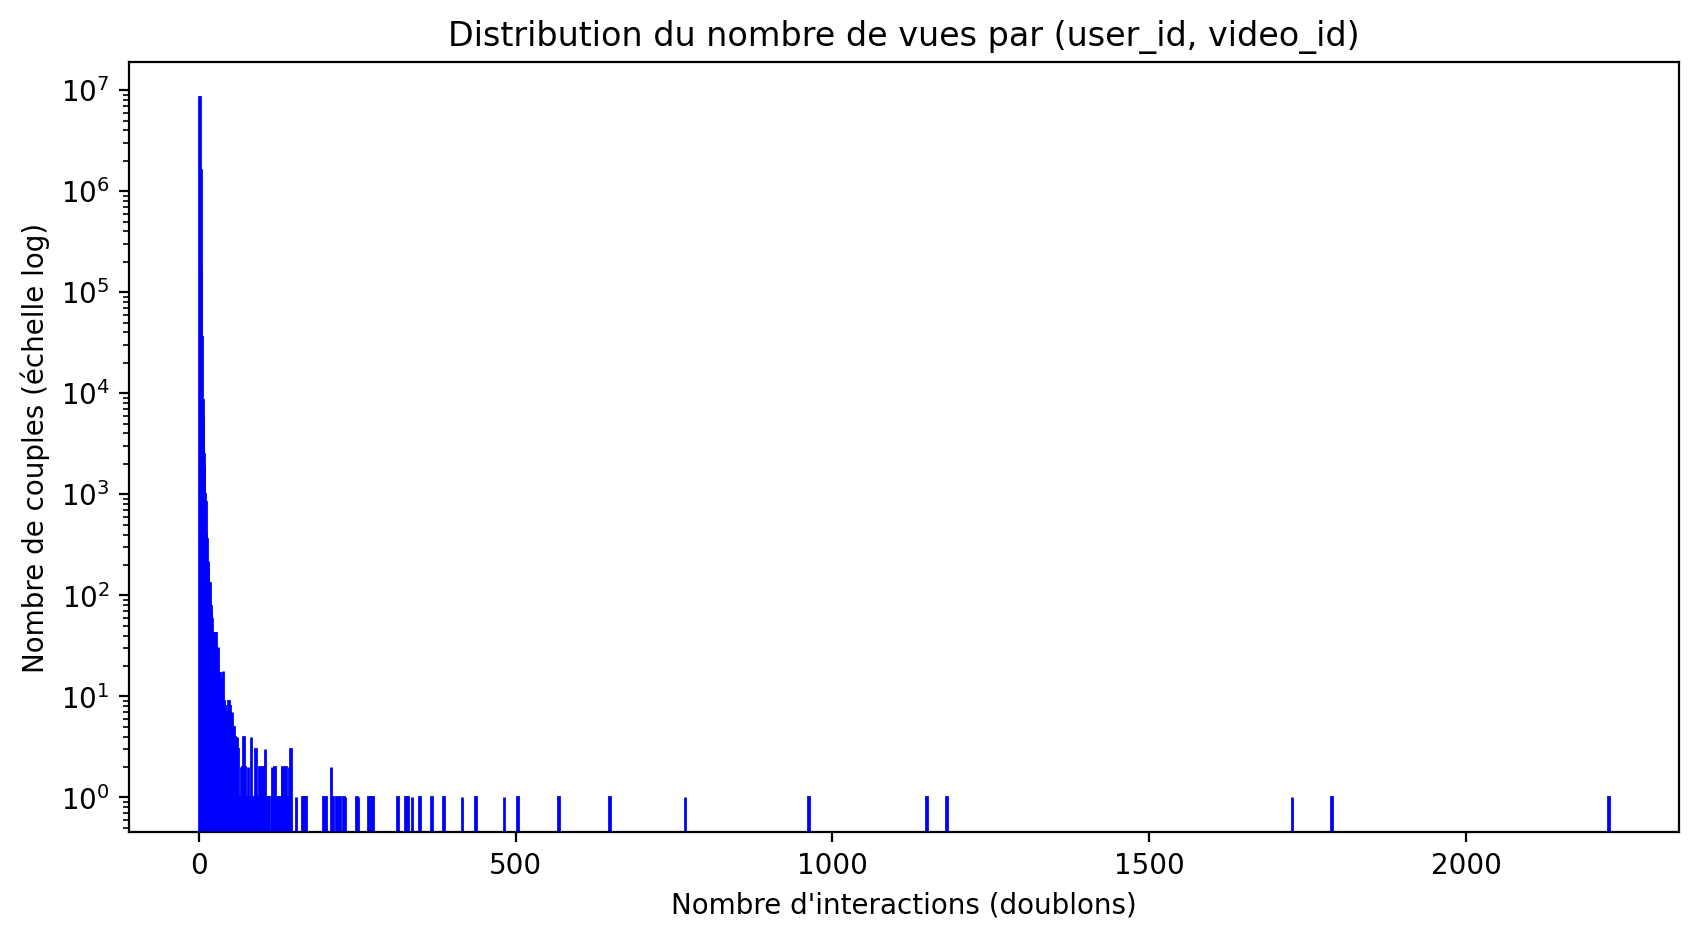

In [5]:
dups = interactions_train.groupby(['user_id', 'video_id']).size().reset_index(name='count')



# Visualiser la distribution (logarithmique si skew)
plt.figure(figsize=(10, 5))
plt.hist(dups['count'], bins=range(1, dups['count'].max() + 2), edgecolor='blue', log=True)
plt.title("Distribution du nombre de vues par (user_id, video_id)")
plt.xlabel("Nombre d'interactions (doublons)")
plt.ylabel("Nombre de couples (échelle log)")
plt.grid(False)
plt.show()

In [21]:
ratio = (interactions_train['watch_ratio'] > 1).sum() / len(interactions_train)
print(f"Nombre de watch_ratio > 1 : {(interactions_train['watch_ratio'] > 1).sum()}")
print(f"Le ratio de watch_ratio > 1 est : {ratio:.2%}")

Nombre de watch_ratio > 1 : 4237441
Le ratio de watch_ratio > 1 est : 33.82%


### On prends le last

In [4]:
interactions_train['date'] = pd.to_datetime(interactions_train['date'])
interactions_train_filtered = interactions_train.sort_values('date').groupby(['user_id', 'video_id']).agg({
    'watch_ratio': 'last'  # ou moyenne pondérée par récence
}).reset_index()

In [7]:
interactions_train['rating'] = np.log1p(interactions_train['watch_ratio']) / np.log1p('max_watch_ratio')

TypeError: ufunc 'log1p' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [5]:
interactions_train['rating'] = interactions_train['watch_ratio'].clip(upper=1.0)


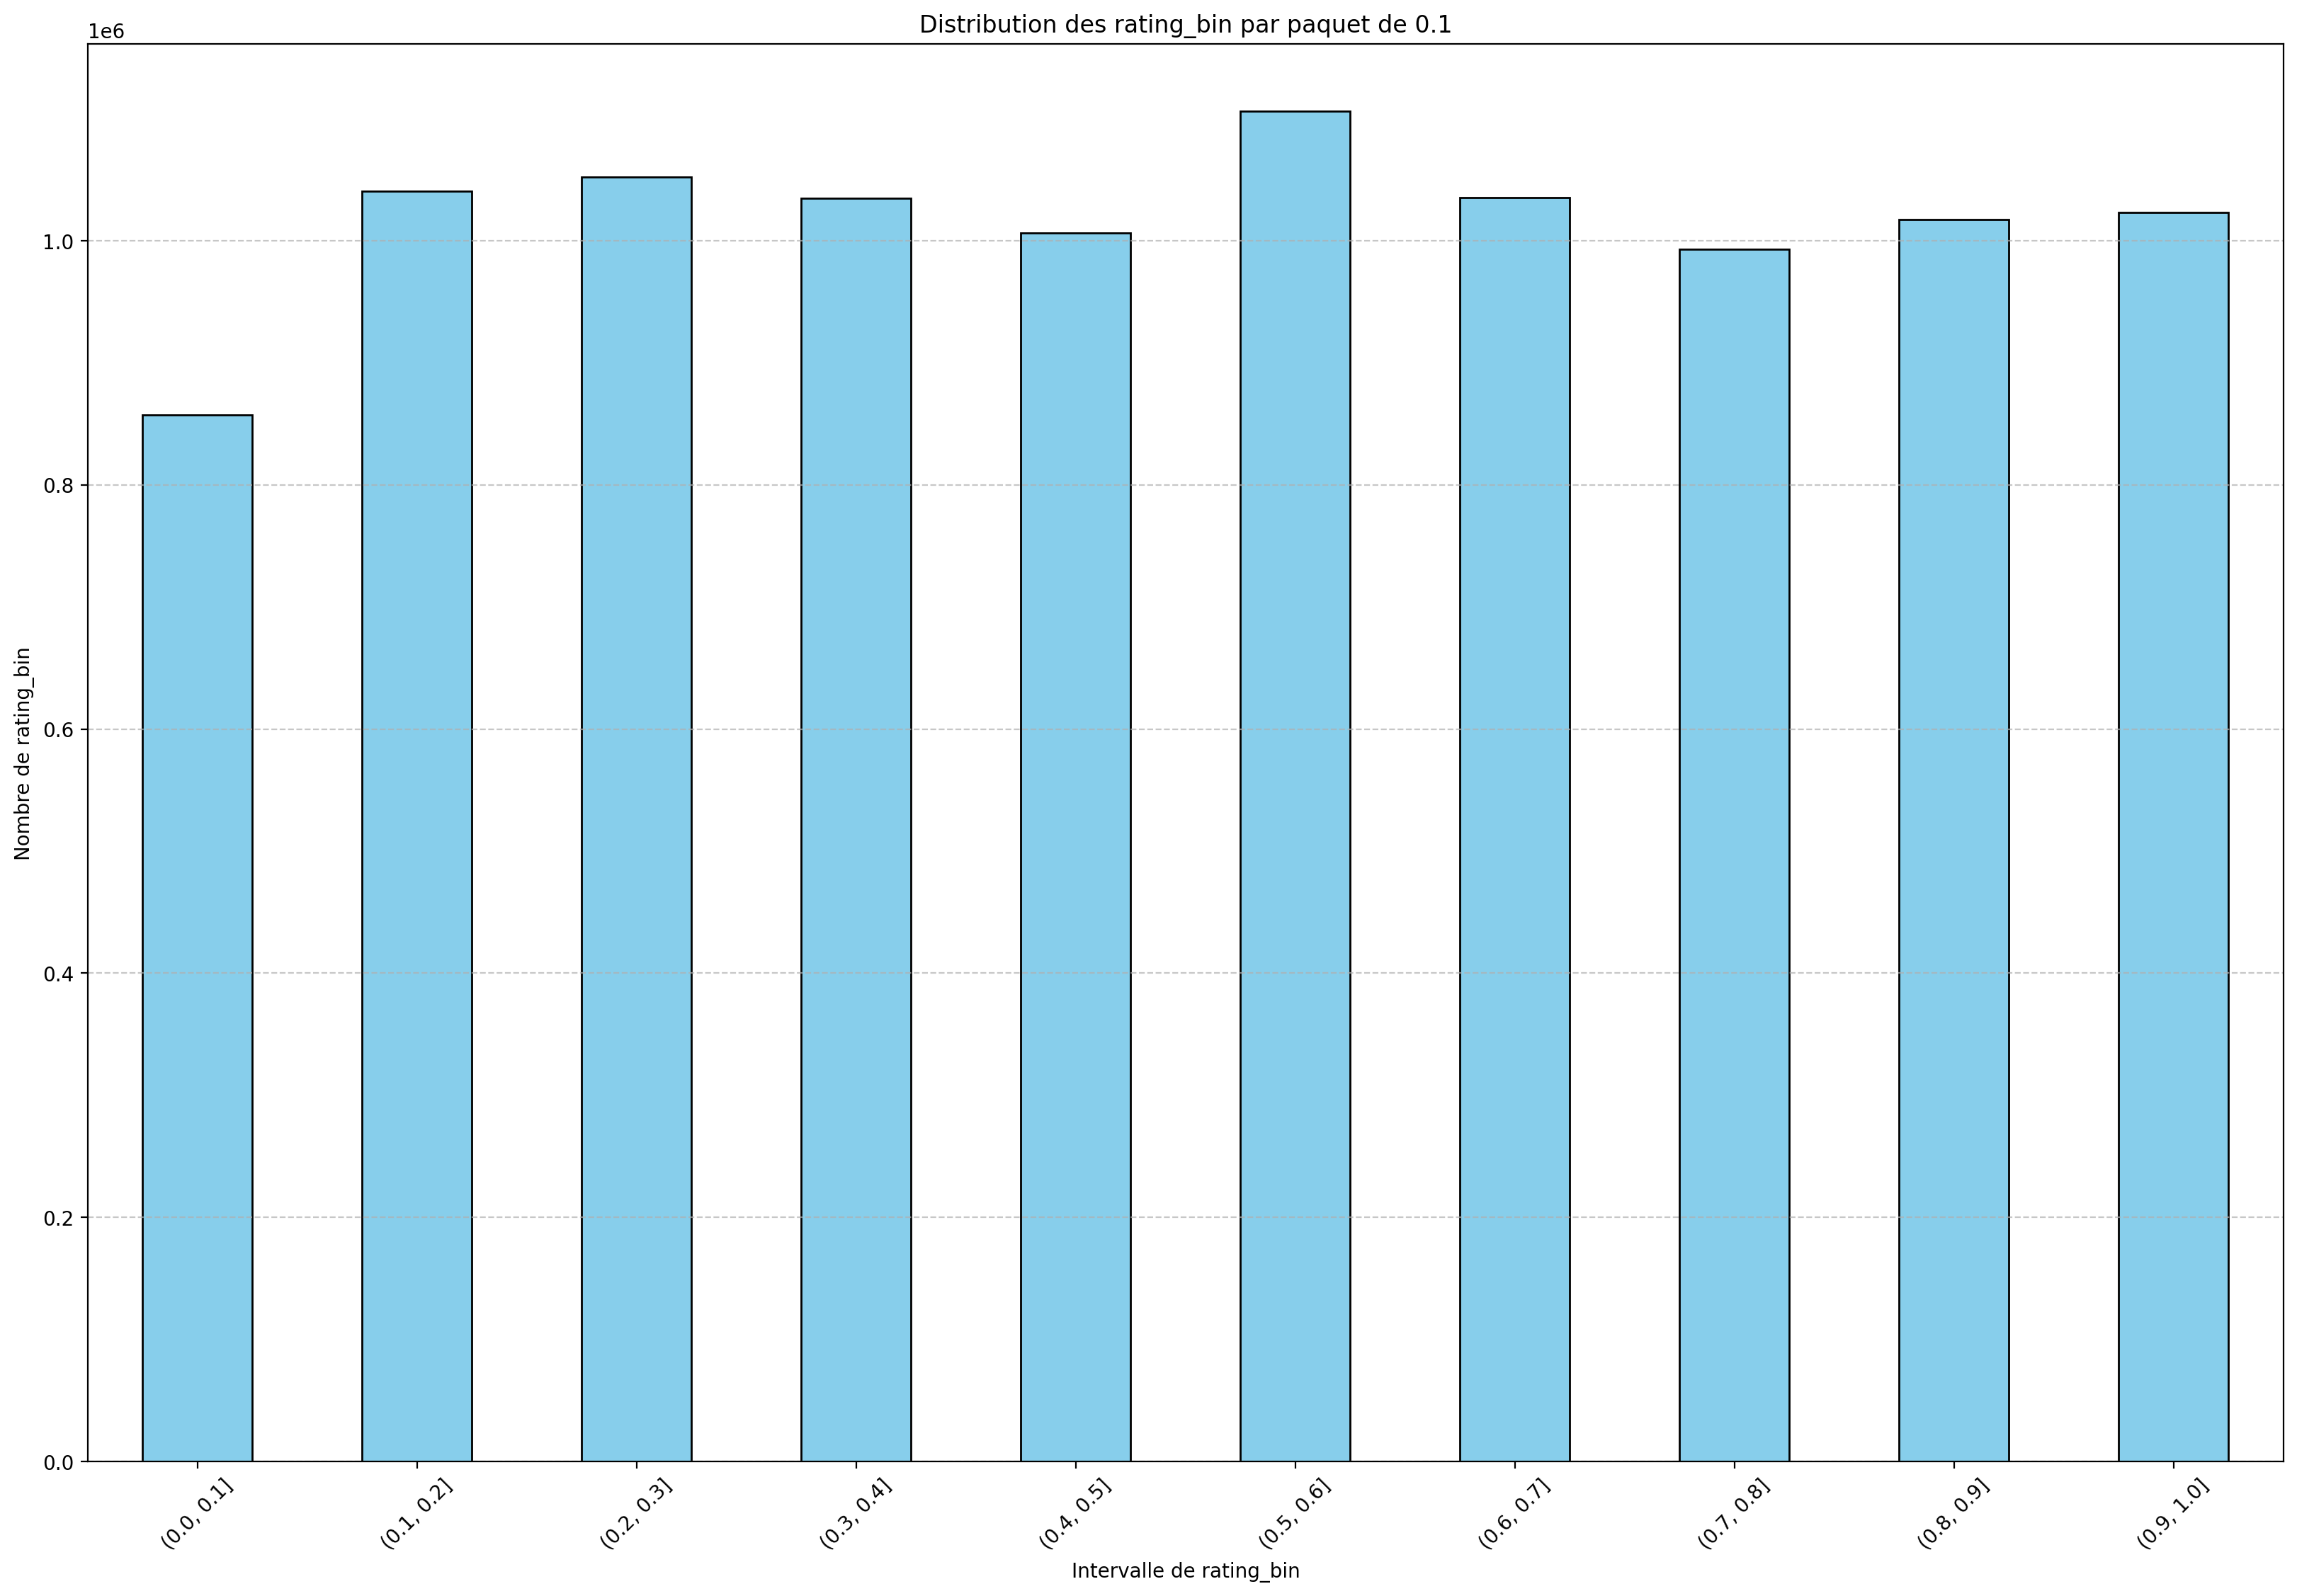

In [5]:
from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(output_distribution='uniform')
#interactions_test['rating'] = qt.fit_transform(interactions_test[['watch_ratio']])


# Convertir les prédictions en pandas si ce n'est pas déjà fait
interactions_train_filtered['rating'] = qt.fit_transform(interactions_train_filtered[['watch_ratio']])
#interactions_train_filtered['rating'] = np.log1p(interactions_train_filtered['watch_ratio'] * 0.8).clip(upper=1.0)
#interactions_train_filtered['rating'] = (np.log1p(interactions_train_filtered['watch_ratio']) / np.log1p(np.max(interactions_train_filtered['rating']))).clip(upper=1.0)
interactions_train_filtered['rating_bin'] = pd.cut(interactions_train_filtered['rating'], bins=np.arange(0, 1.1, 0.1))

# Compter le nombre de prédictions dans chaque intervalle
bin_counts = interactions_train_filtered['rating_bin'].value_counts().sort_index()

# Tracer l'histogramme
bin_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Distribution des rating_bin par paquet de 0.1")
plt.xlabel("Intervalle de rating_bin")
plt.ylabel("Nombre de rating_bin")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [6]:
#interactions_test['rating'] = np.log1p(interactions_test['watch_ratio'] * 0.8).clip(upper=1.0)
interactions_test['rating'] = qt.transform(interactions_test[['watch_ratio']])
interactions_test

,user_id,video_id,play_duration,video_duration,time,date,timestamp,watch_ratio,rating
0,14,148,4381,6067,2020-07-05 05:27:48.378,20200705.0,1.593898e+09,0.722103,0.492431
1,14,183,11635,6100,2020-07-05 05:28:00.057,20200705.0,1.593898e+09,1.907377,0.913094
2,14,3649,22422,10867,2020-07-05 05:29:09.479,20200705.0,1.593898e+09,2.063311,0.929231
3,14,5262,4479,7908,2020-07-05 05:30:43.285,20200705.0,1.593898e+09,0.566388,0.390256
4,14,8234,4602,11000,2020-07-05 05:35:43.459,20200705.0,1.593899e+09,0.418364,0.300763
...,...,...,...,...,...,...,...,...,...
4676565,7162,2267,11908,5467,NaN,NaN,NaN,2.178160,0.938055
4676566,7162,2065,11919,6067,NaN,NaN,NaN,1.964562,0.919544
4676567,7162,1296,16690,19870,NaN,NaN,NaN,0.839960,0.561160
4676568,7162,4822,11862,24400,NaN,NaN,NaN,0.486148,0.338728


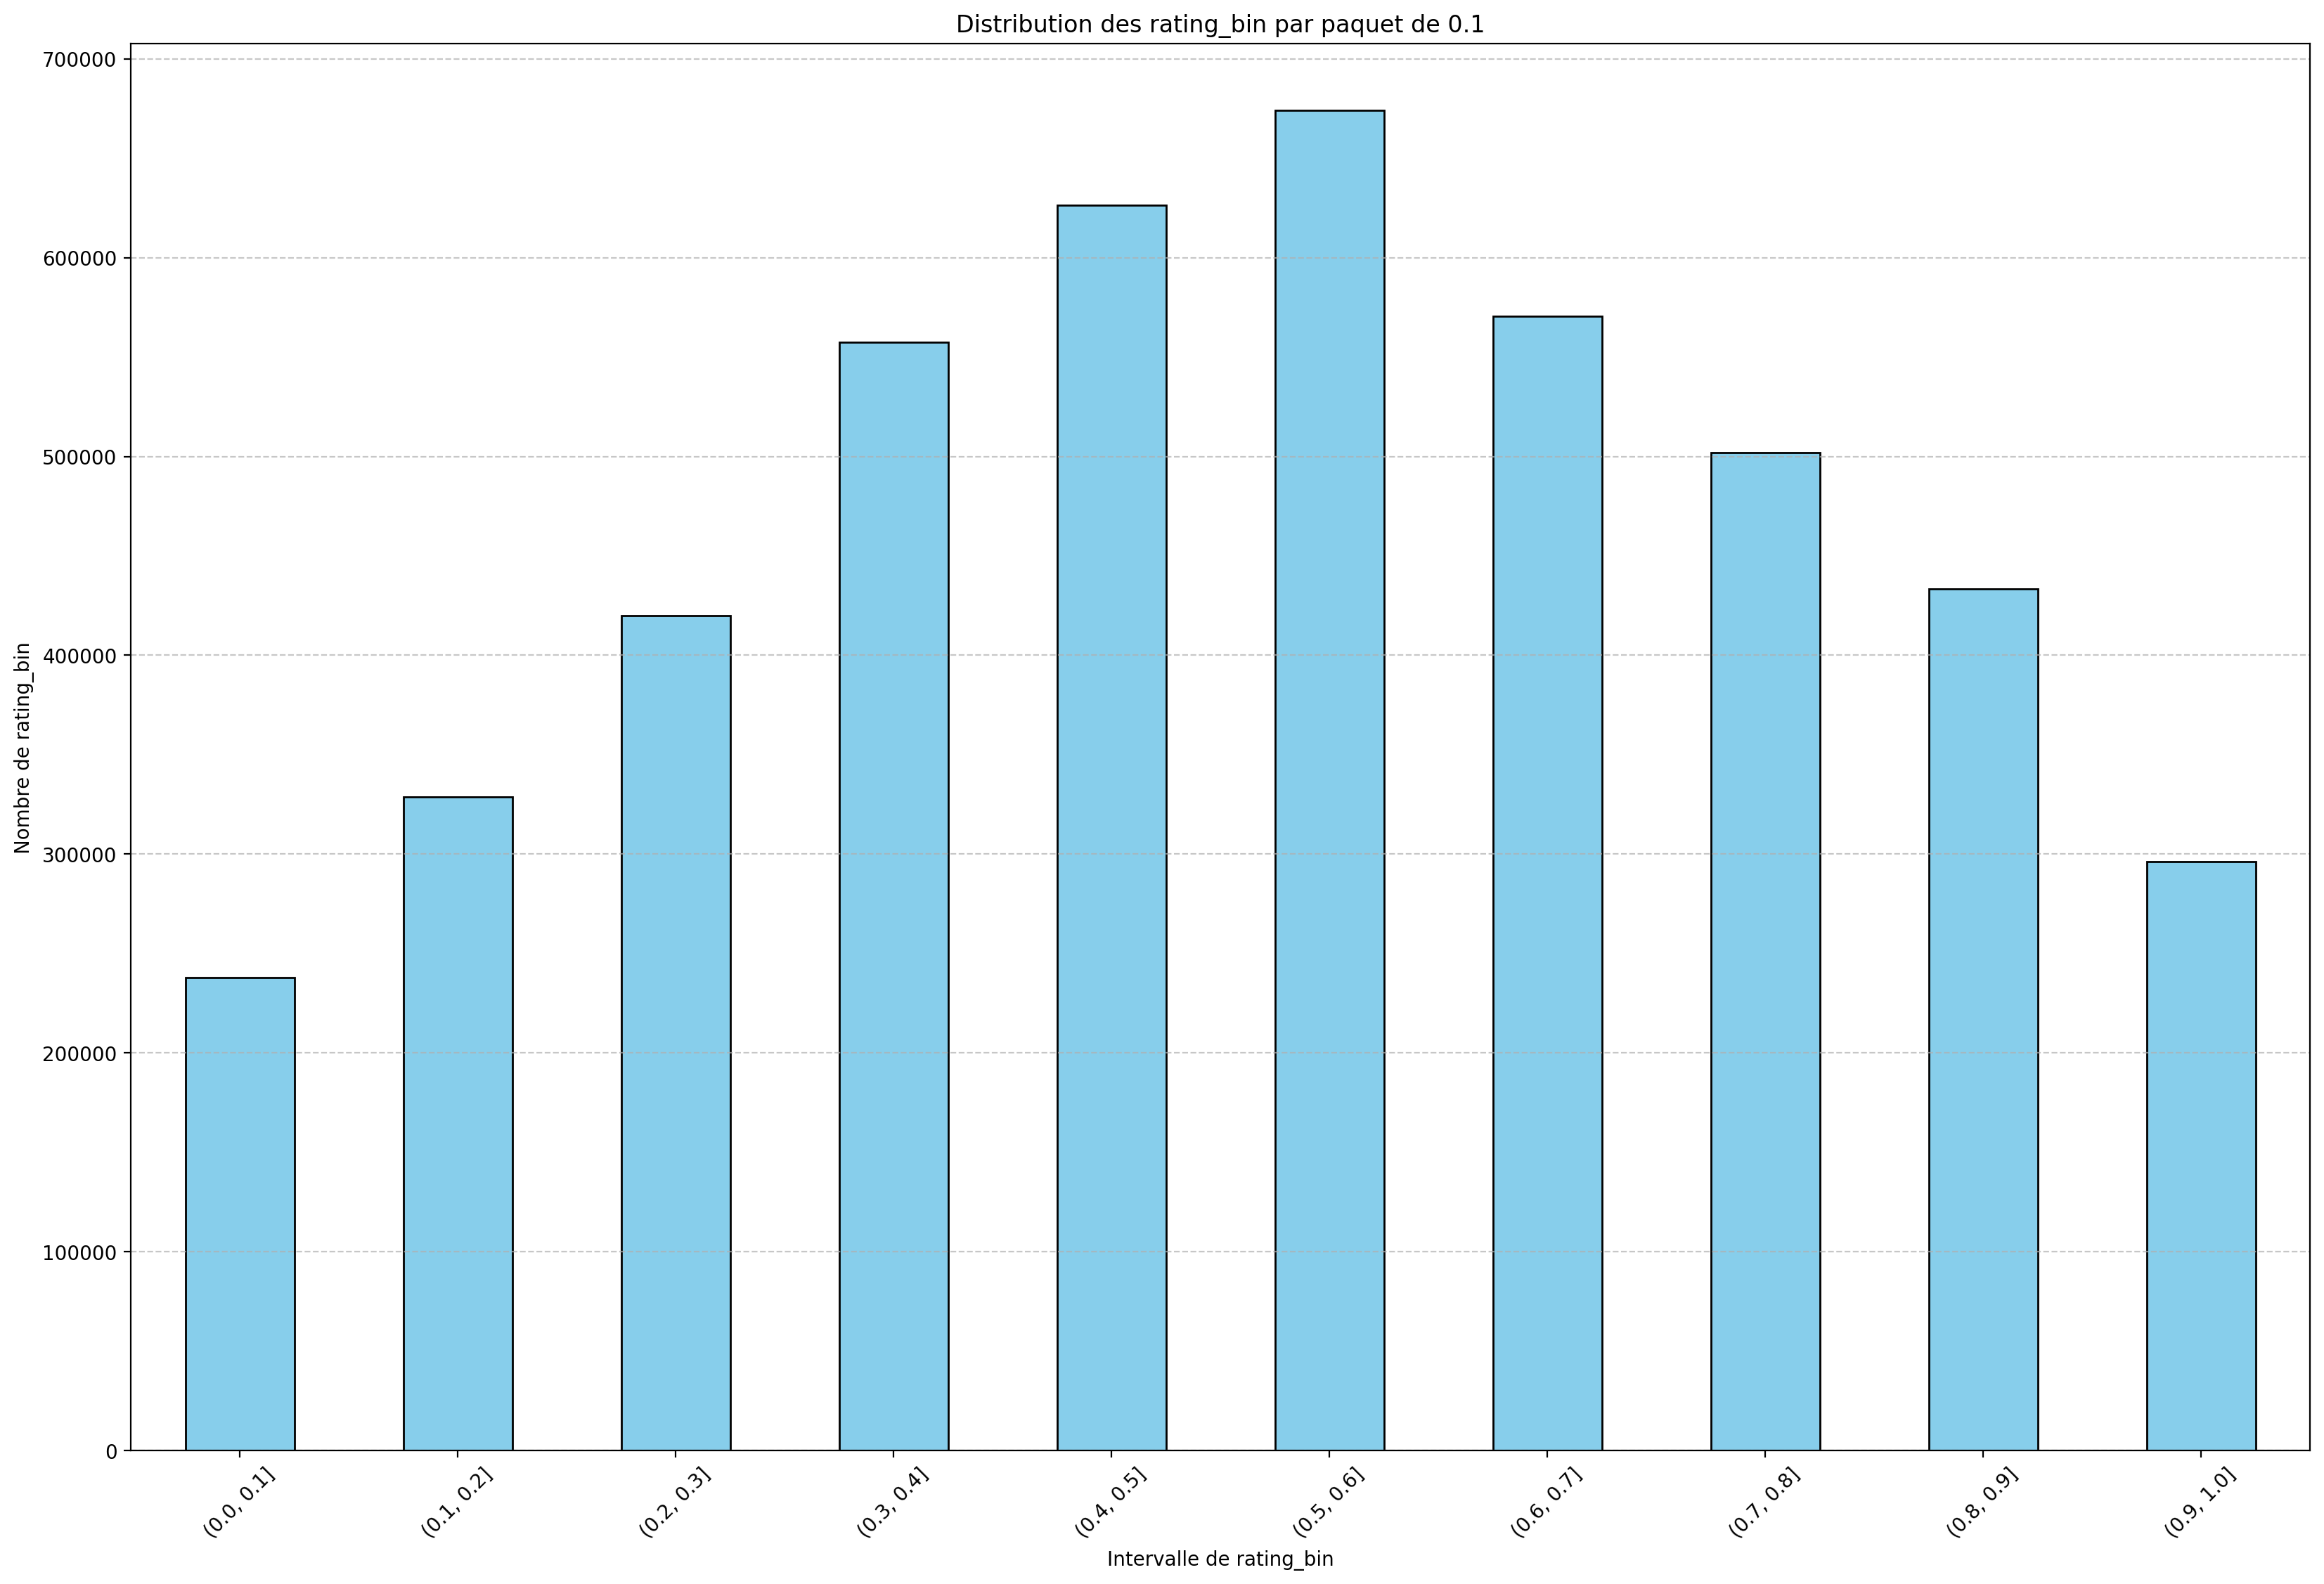

In [7]:
interactions_test['rating_bin'] = pd.cut(interactions_test['rating'], bins=np.arange(0, 1.1, 0.1))

# Compter le nombre de prédictions dans chaque intervalle
bin_counts = interactions_test['rating_bin'].value_counts().sort_index()

# Tracer l'histogramme
bin_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Distribution des rating_bin par paquet de 0.1")
plt.xlabel("Intervalle de rating_bin")
plt.ylabel("Nombre de rating_bin")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [8]:
interactions_train_filtered[['user_id', 'video_id', 'rating']].to_csv("interactions_train_filtered_quantile.csv", index=False)
interactions_test[['user_id', 'video_id', 'rating']].to_csv("interactions_test_filtered_qunatile.csv", index=False)


# ALS

In [9]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

import matplotlib.pyplot as plt
import logging

In [10]:
spark = SparkSession.builder.appName("ALSMatrixFactorisation").config("spark.driver.memory", "12g") .getOrCreate()

In [11]:
df = spark.read.option("header", "true").csv("./interactions_train_filtered_quantile.csv")
df.show(100, truncate=True)

+-------+--------+--------------------+
|user_id|video_id|              rating|
+-------+--------+--------------------+
|      0|      42|  0.7006837625365878|
|      0|      67|  0.9666260359410923|
|      0|      80|  0.7460854165358518|
|      0|     110|  0.8218306963518461|
|      0|     128|  0.7826862111715659|
|      0|     130| 0.06319899605776104|
|      0|     133|  0.9532269414659997|
|      0|     139| 0.05753476483672201|
|      0|     147| 0.06091164543728787|
|      0|     151|  0.8676071396512685|
|      0|     152|   0.947076027350726|
|      0|     154|  0.9885728963950345|
|      0|     166| 0.11954769044362946|
|      0|     169|  0.8080798764084702|
|      0|     170|  0.8132536823755531|
|      0|     171|  0.9991858377898313|
|      0|     179|  0.9370300486800942|
|      0|     180|  0.7727997627489069|
|      0|     183| 0.10792713542576482|
|      0|     188|    0.80344184856561|
|      0|     203| 0.05946523032147395|
|      0|     206|  0.0631636450585973|


In [12]:
from pyspark.sql.functions import col, when

In [29]:
indexer = [
    StringIndexer(inputCol=column, outputCol=column + "_index")
    for column in ['user_id', 'video_id']
]

pipeline = Pipeline(stages=indexer)

# 2. Entraîner le pipeline
pipeline_model = pipeline.fit(df)

# 3. Transformer les données d'entraînement
transformed = pipeline_model.transform(df)

# 4. Forcer rating en float
transformed = transformed.withColumn("rating", col("rating").cast("float"))

# 5. Entraîner le modèle ALS

# ------------------------
# Données de test : small_matrix
# ------------------------

# 6. Charger small_matrix.csv
small_matrix_spark = spark.read.option("header", "true").csv("./interactions_train_filtered_quantile.csv")


# 10. Transformer avec le pipeline entraîné
small_matrix_transformed = pipeline_model.transform(small_matrix_spark)

# 11. Forcer rating en float
small_matrix_transformed = small_matrix_transformed.withColumn("rating", col("rating").cast("float"))


als = ALS(
    maxIter=5,
    regParam=0.09,
    rank=100 ,
    userCol="user_id_index",
    itemCol="video_id_index",
    ratingCol="rating",
    coldStartStrategy="drop",
    nonnegative=True,
)
model = als.fit(transformed)



# 12. Prédictions
predictions = model.transform(small_matrix_transformed)

# 13. Affichage
predictions.show()

+-------+--------+-----------+-------------+--------------+----------+
|user_id|video_id|     rating|user_id_index|video_id_index|prediction|
+-------+--------+-----------+-------------+--------------+----------+
|   1083|    3417|  0.9989577|       3997.0|        4101.0|0.28053713|
|   1083|    3809|  0.9763561|       3997.0|         496.0|0.44446644|
|   1083|    6178| 0.22690223|       3997.0|        2122.0| 0.4863834|
|   1083|    8743| 0.99827605|       3997.0|         463.0|0.53338224|
|   1083|    8915|0.016984276|       3997.0|         148.0|0.09286972|
|   1083|   10297|        1.0|       3997.0|         833.0|0.45672202|
|   1237|    4220|  0.1330778|       1959.0|        1959.0| 0.3961907|
|   1237|    4270| 0.58386743|       1959.0|         471.0|0.40087596|
|   1237|    6177|  0.1412203|       1959.0|        1342.0| 0.4364875|
|   1237|    8630|  0.5137379|       1959.0|        1580.0| 0.3963996|
|   1237|    8743| 0.25091264|       1959.0|         463.0|0.47716922|
|   12

In [14]:
predictions.filter(col("prediction") >= 1.0).count()

23

In [15]:
predictions.select("user_id", "video_id", "prediction").show(100, truncate=True)

+-------+--------+-----------+
|user_id|video_id| prediction|
+-------+--------+-----------+
|   1083|      72| 0.32445386|
|   1083|     151|  0.4610161|
|   1083|     153| 0.34798416|
|   1083|     154|  0.6396406|
|   1083|     166|  0.5593215|
|   1083|     175|  0.1157343|
|   1083|     179| 0.51961446|
|   1083|     180| 0.38287392|
|   1083|     183|  0.5363381|
|   1083|     188| 0.40416613|
|   1083|     190| 0.42704824|
|   1083|     206|  0.4236057|
|   1083|     210| 0.39623052|
|   1083|     211| 0.57709527|
|   1083|     217| 0.56505996|
|   1083|     223| 0.23239055|
|   1083|     237|  0.3760726|
|   1083|     239| 0.30340162|
|   1083|     243|  0.4243798|
|   1083|     256| 0.35926983|
|   1083|     265| 0.48307714|
|   1083|     273| 0.30818075|
|   1083|     275| 0.30231243|
|   1083|     279|  0.3374823|
|   1083|     280| 0.35219082|
|   1083|     282| 0.23964365|
|   1083|     283|  0.3238138|
|   1083|     285| 0.13357048|
|   1083|     288| 0.41854185|
|   1083

In [30]:

predictions_pandas = predictions.toPandas()

# Afficher les premières lignes pour vérifier
print(predictions_pandas.head())

  user_id video_id    rating  user_id_index  video_id_index  prediction
0    1083     3417  0.998958         3997.0          4101.0    0.280537
1    1083     3809  0.976356         3997.0           496.0    0.444466
2    1083     6178  0.226902         3997.0          2122.0    0.486383
3    1083     8743  0.998276         3997.0           463.0    0.533382
4    1083     8915  0.016984         3997.0           148.0    0.092870


In [27]:
def evaluate_at_k(df, k, threshold=0.5):
    # Créer la colonne 'relevant' avant toute manipulation
    df['relevant'] = (df['rating'] > threshold).astype(int)

    # Trier les prédictions par utilisateur et score décroissant
    df_sorted = df.sort_values(by=['user_id', 'prediction'], ascending=[True, False])

    # Ajouter le rang de chaque élément par utilisateur
    df_sorted['rank'] = df_sorted.groupby('user_id').cumcount() + 1

    # Garder le top-k par utilisateur
    top_k = df_sorted[df_sorted['rank'] <= k].copy()  # Utiliser .copy() pour éviter la vue

    # Precision@k
    precision_per_user = top_k.groupby('user_id')['relevant'].mean()

    # Recall@k
    total_relevant_per_user = df[df['relevant'] == 1].groupby('user_id').size()
    recall_per_user = top_k.groupby('user_id')['relevant'].sum() / total_relevant_per_user

    # DCG@k
    top_k['dcg'] = (2 ** top_k['relevant'] - 1) / np.log2(top_k['rank'] + 1)
    dcg = top_k.groupby('user_id')['dcg'].sum()

    # IDCG@k
    ideal = df.sort_values(by=['user_id', 'relevant'], ascending=[True, False])
    ideal['rank'] = ideal.groupby('user_id').cumcount() + 1
    ideal_top_k = ideal[ideal['rank'] <= k].copy()
    ideal_top_k['idcg'] = (2 ** ideal_top_k['relevant'] - 1) / np.log2(ideal_top_k['rank'] + 1)
    idcg = ideal_top_k.groupby('user_id')['idcg'].sum()

    ndcg = (dcg / idcg).fillna(0)

    # MAP@k
    def average_precision(group):
        relevant = group['relevant'].values
        if relevant.sum() == 0:
            return 0.0
        precisions = [(relevant[:i+1].sum() / (i+1)) for i in range(len(relevant)) if relevant[i]]
        return np.mean(precisions)

    map_per_user = top_k.groupby('user_id', group_keys=False).apply(average_precision)


    # Retourner les résultats sous forme de dictionnaire
    return {
        'precision': precision_per_user.mean(),
        'recall': recall_per_user.mean(),
        'ndcg': ndcg.mean(),
        'map': map_per_user.mean()
    }



In [18]:
from sklearn.metrics import mean_absolute_error

# Calculer la MAE
mae = mean_absolute_error(predictions_pandas['rating'], predictions_pandas['prediction'])
print(f"Mean Absolute Error (MAE): {mae:.4f}")

Mean Absolute Error (MAE): 0.1930


In [ ]:


# Utilisation
k = 10
recall = recall_at_k_pandas(predictions_pandas, k, threshold=0.90)
print(f"Recall at {k}: {recall:.2%}")

In [43]:
evaluator = RegressionEvaluator(
    metricName="mae", 
    labelCol="rating", 
    predictionCol="prediction"
)

mae = evaluator.evaluate(predictions)
print(f"Mean Absolute Error (MAE): {mae:.4f}")

Mean Absolute Error (MAE): 0.1856


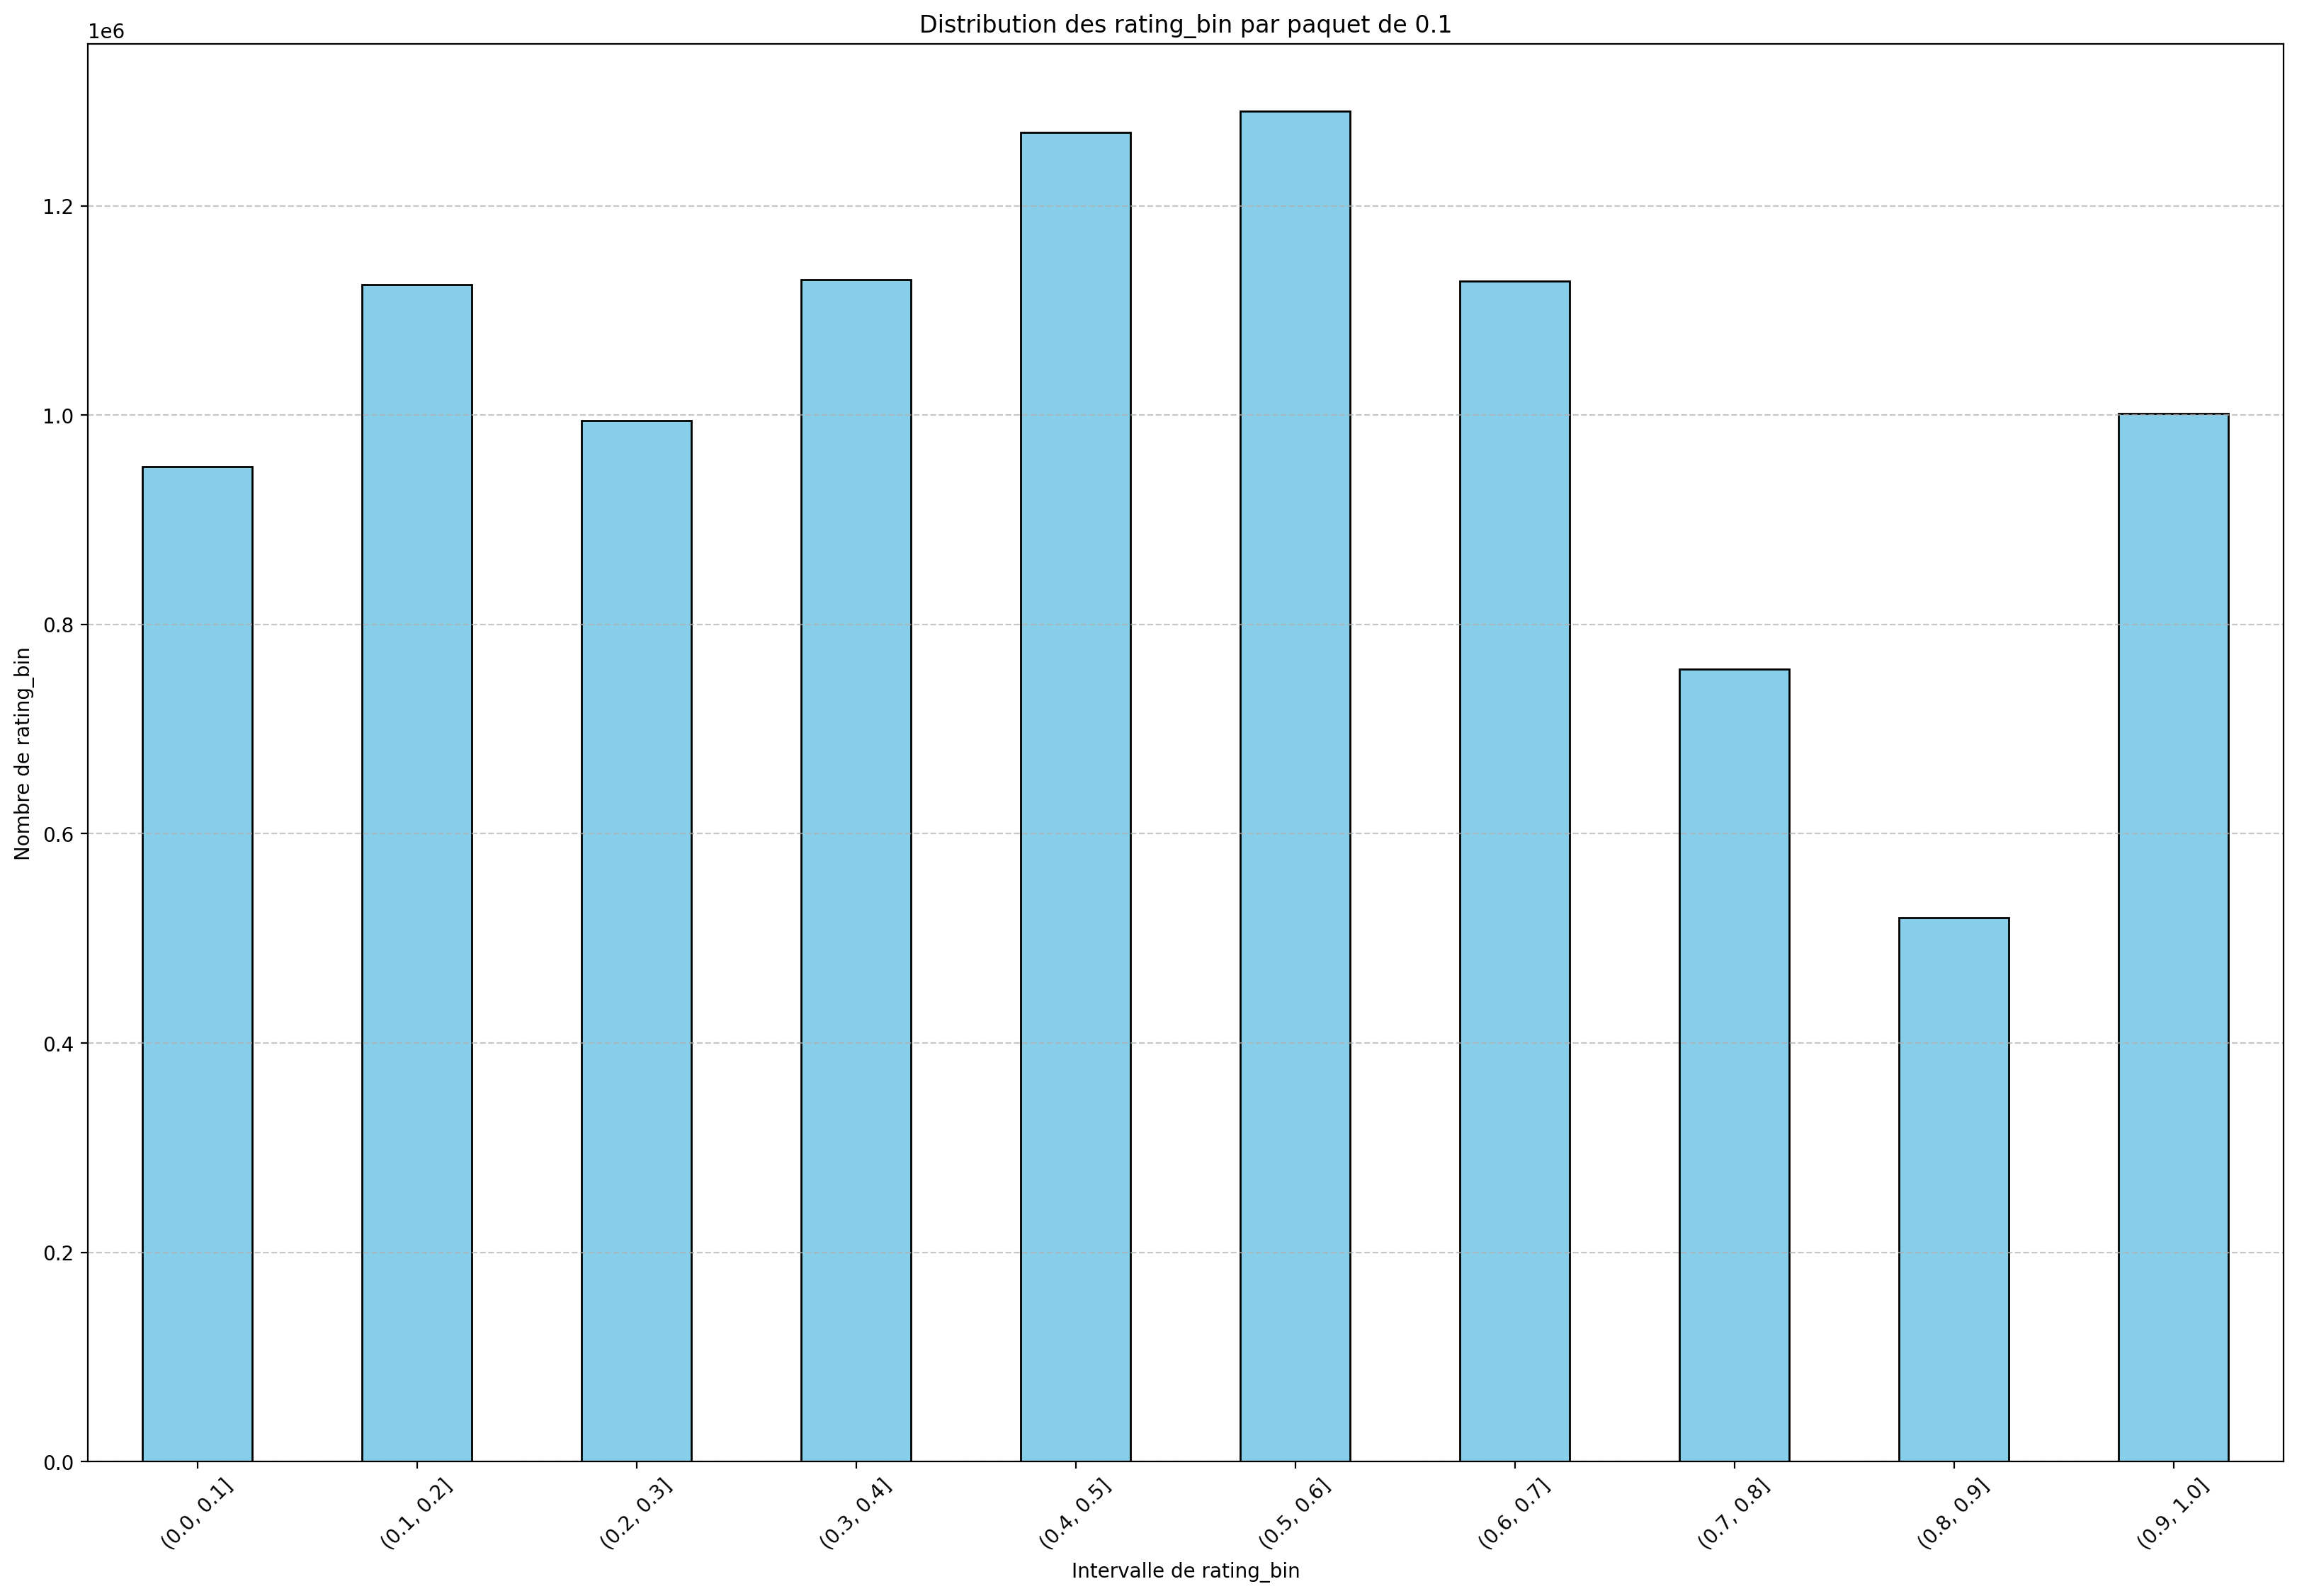

In [14]:
# Convertir les prédictions en pandas si ce n'est pas déjà fait
predictions_pandas['rating_bin'] = pd.cut(predictions_pandas['rating'], bins=np.arange(0, 1.1, 0.1))

# Compter le nombre de prédictions dans chaque intervalle
bin_counts = predictions_pandas['rating_bin'].value_counts().sort_index()

# Tracer l'histogramme
bin_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Distribution des rating_bin par paquet de 0.1")
plt.xlabel("Intervalle de rating_bin")
plt.ylabel("Nombre de rating_bin")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [42]:
count_ratings = predictions_pandas[predictions_pandas['rating'] > 0.9].shape[0]
print(f"Nombre de ratings > 0.9 : {count_ratings/len(predictions_pandas):.2%}")

Nombre de ratings > 0.9 : 9.72%


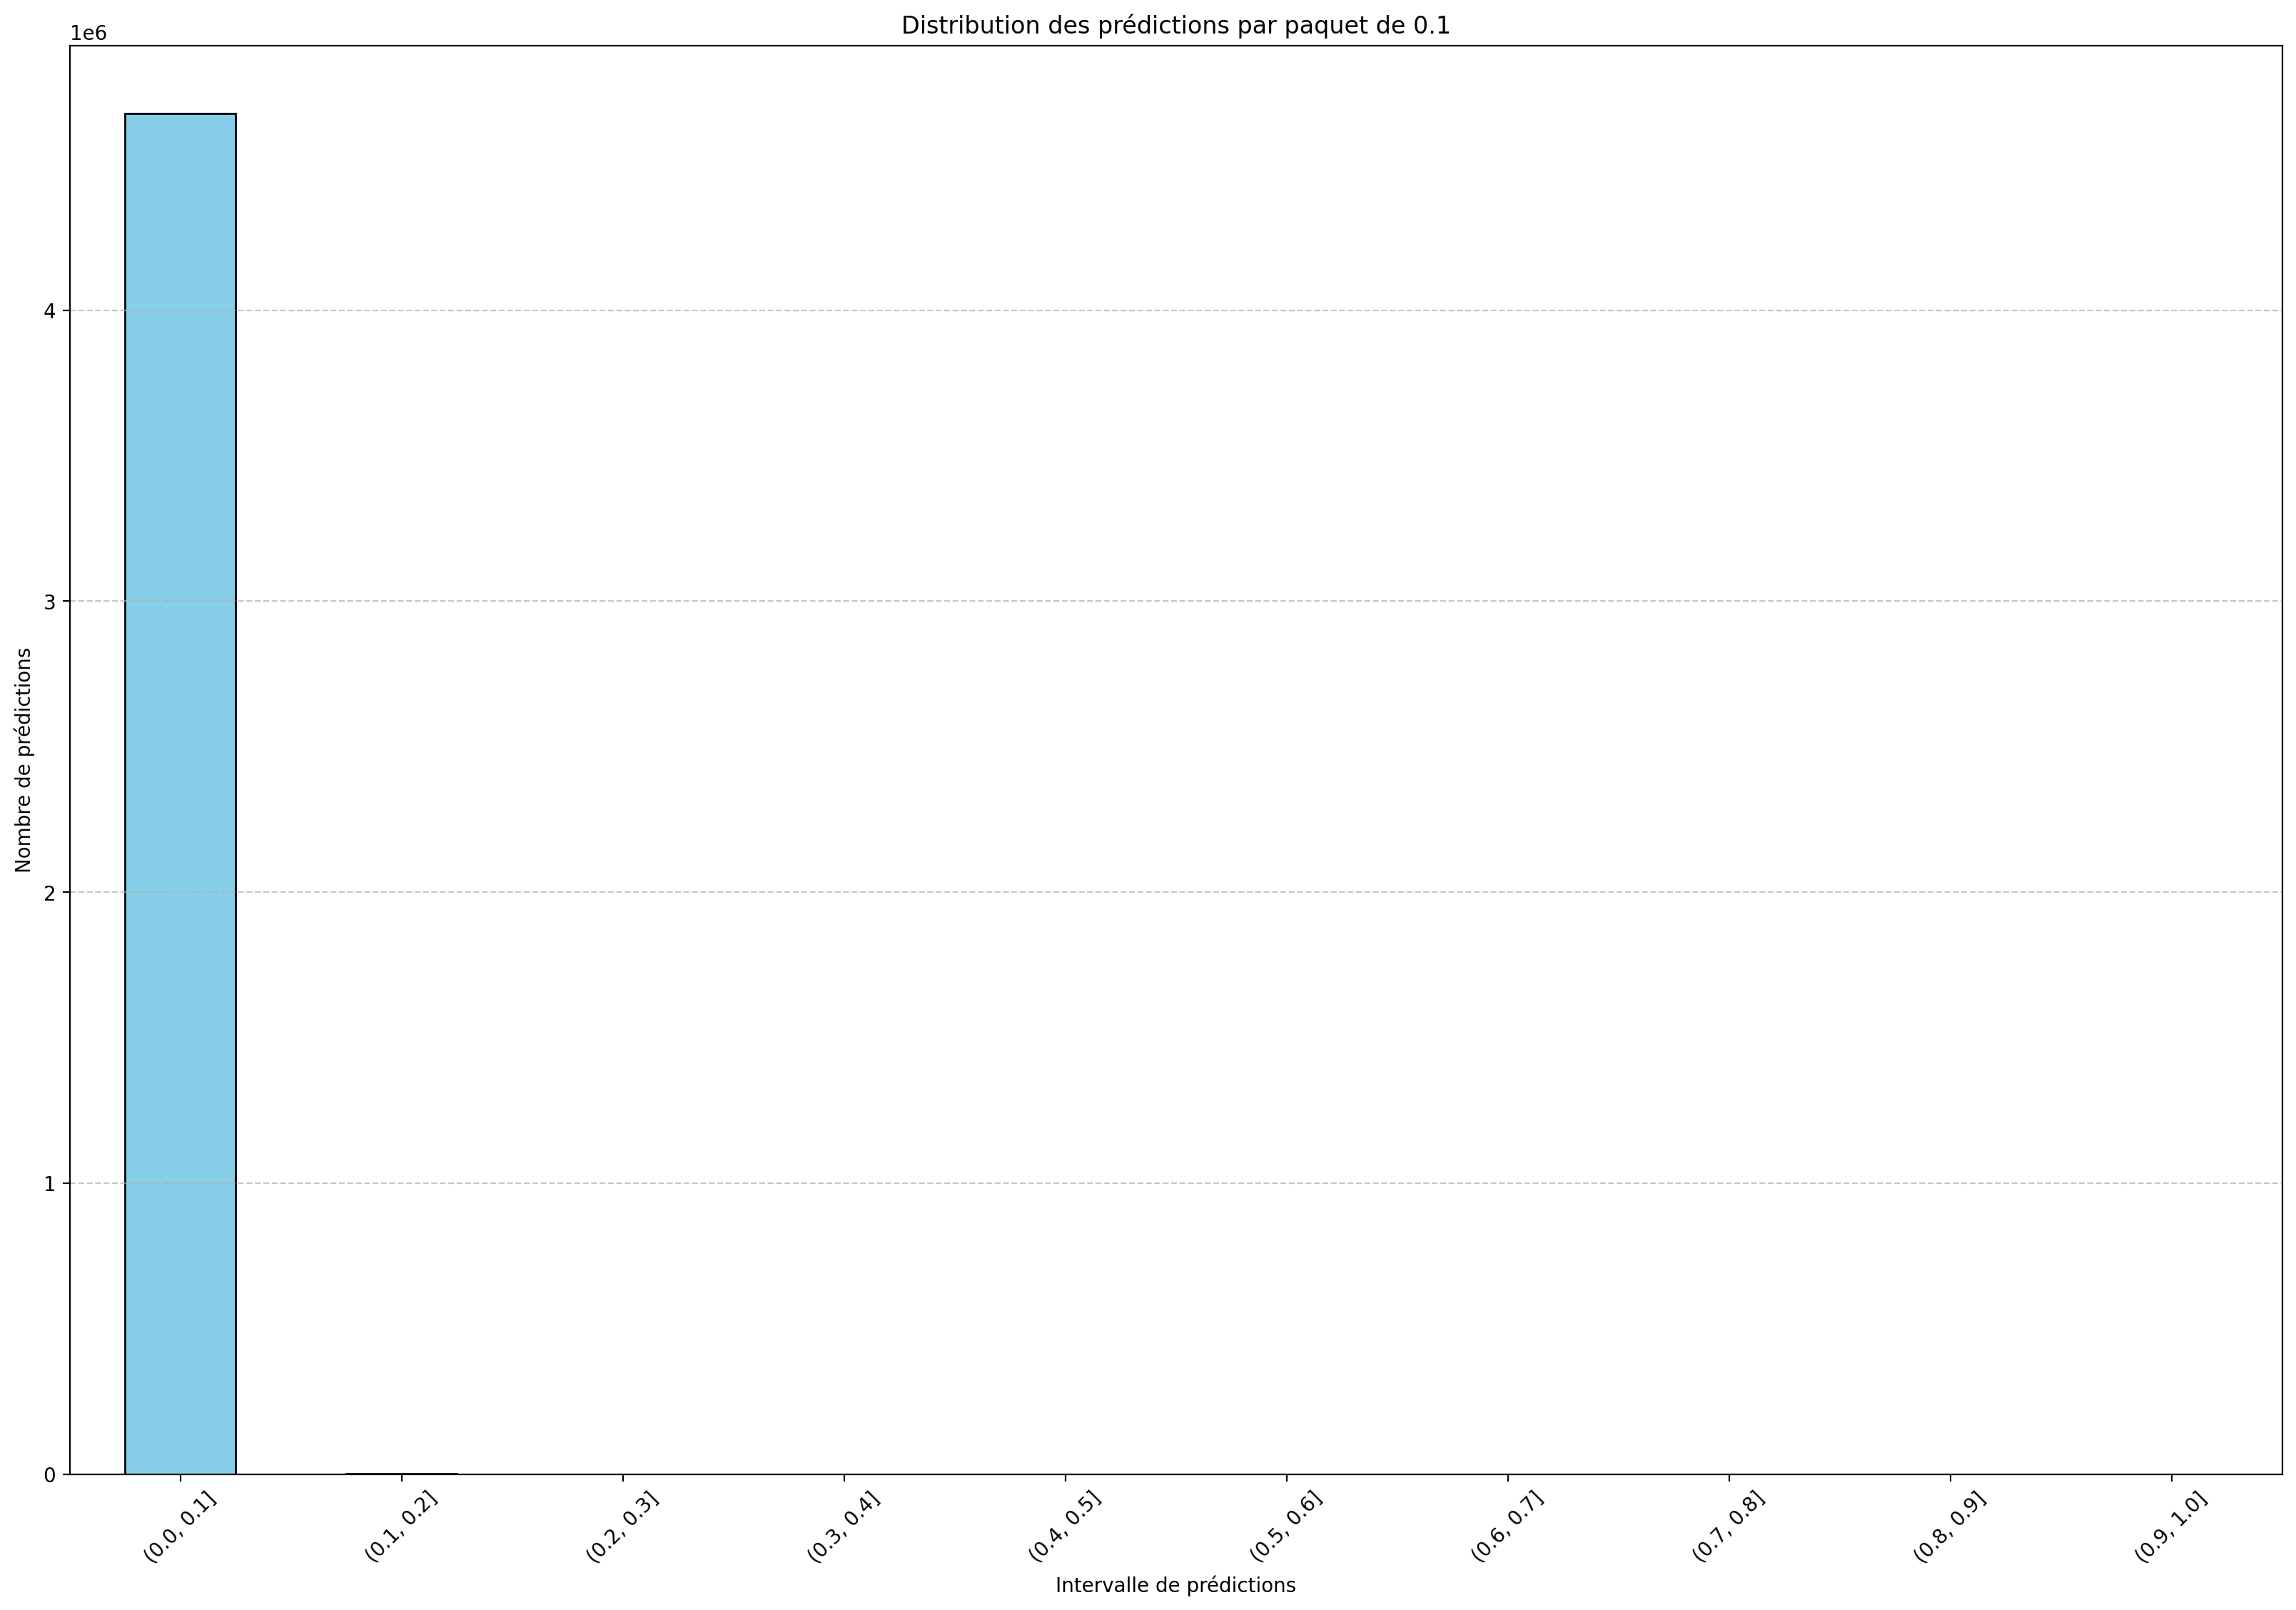

In [21]:
# Convertir les prédictions en pandas si ce n'est pas déjà fait
predictions_pandas['prediction_bin'] = pd.cut(predictions_pandas['prediction'], bins=np.arange(0, 1.1, 0.1))

# Compter le nombre de prédictions dans chaque intervalle
bin_counts = predictions_pandas['prediction_bin'].value_counts().sort_index()

# Tracer l'histogramme
bin_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Distribution des prédictions par paquet de 0.1")
plt.xlabel("Intervalle de prédictions")
plt.ylabel("Nombre de prédictions")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [31]:
evaluate_at_k(predictions_pandas, k=10, threshold=0.9)

C:\Users\letru\AppData\Local\Temp\ipykernel_11292\554150683.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  map_per_user = top_k.groupby('user_id', group_keys=False).apply(average_precision)


{'precision': np.float64(0.5893255295429208),
 'recall': np.float64(0.08794066089217546),
 'ndcg': np.float64(0.6027359100646874),
 'map': np.float64(0.7033949973445962)}

IndexError: list index out of range

In [28]:
# Initialiser les listes pour stocker les résultats
ks = range(1, 51)
precisions = []
ndcgs = []
recalls = []
maps = []

# Calculer les métriques pour chaque valeur de k
for k in ks:
    print(f"Calculating metrics for k={k}...")
    evaluate = evaluate_at_k(predictions_pandas, k, threshold=0.9)   
    precisions.append(evaluate['precision'])
    ndcgs.append(evaluate['ndcg'])
    recalls.append(evaluate['recall'])
    maps.append(evaluate['map'])

# Tracer les résultats
plt.figure(figsize=(10, 6))
plt.plot(ks, precisions, label="Precision", marker='o')
plt.plot(ks, ndcgs, label="NDCG", marker='s')
plt.plot(ks, recalls, label="Recall", marker='^')
plt.plot(ks, maps, label="MAP", marker='x')
plt.title("Precision, NDCG, and Recall vs K (Threshold = 0.9)")
plt.xlabel("K")
plt.ylabel("Metric Value")
plt.legend()
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.show()

Calculating metrics for k=1...


KeyboardInterrupt: 

In [ ]:
for rank in [10, 25, 50, 100]:
    als = ALS(
        maxIter=5,
        regParam=0.01,
        rank=rank,
        userCol="user_id_index",
        itemCol="video_id_index",
        ratingCol="rating",
        coldStartStrategy="drop",
        nonnegative=True
    )
    model = als.fit(transformed)
    predictions = model.transform(small_matrix_transformed)
    predictions_pandas = predictions.toPandas()
    metrics = evaluate_at_k(predictions_pandas, k=10,threshold=0.9)  # ou ton éval
    print(f"Rank = {rank}, NDCG@10 = {metrics['ndcg']:.4f}, MAP@10 = {metrics['map']:.4f}, Precision@10 = {metrics['precision']:.4f}, Recall@10 = {metrics['recall']:.4f}")


C:\Users\letru\AppData\Local\Temp\ipykernel_11292\554150683.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  map_per_user = top_k.groupby('user_id', group_keys=False).apply(average_precision)


Rank = 10, NDCG@10 = 0.6030, MAP@10 = 0.7039, Precision@10 = 0.5895, Recall@10 = 0.0879


C:\Users\letru\AppData\Local\Temp\ipykernel_11292\554150683.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  map_per_user = top_k.groupby('user_id', group_keys=False).apply(average_precision)


Rank = 25, NDCG@10 = 0.6028, MAP@10 = 0.7038, Precision@10 = 0.5893, Recall@10 = 0.0879


C:\Users\letru\AppData\Local\Temp\ipykernel_11292\554150683.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  map_per_user = top_k.groupby('user_id', group_keys=False).apply(average_precision)


Rank = 50, NDCG@10 = 0.6028, MAP@10 = 0.7037, Precision@10 = 0.5893, Recall@10 = 0.0880


C:\Users\letru\AppData\Local\Temp\ipykernel_11292\554150683.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  map_per_user = top_k.groupby('user_id', group_keys=False).apply(average_precision)


Rank = 100, NDCG@10 = 0.6028, MAP@10 = 0.7036, Precision@10 = 0.5893, Recall@10 = 0.0880
